<a href="https://colab.research.google.com/github/kolmar7/rdf/blob/main/RDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radial distribution function

Maria Kolonsky 2025

v.0.2.0

In [29]:
#! pip install shapely
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from shapely.geometry import Point, box, Polygon
from shapely.prepared import prep
from shapely.strtree import STRtree


## Parse XML datafile for $(x, y)$ points

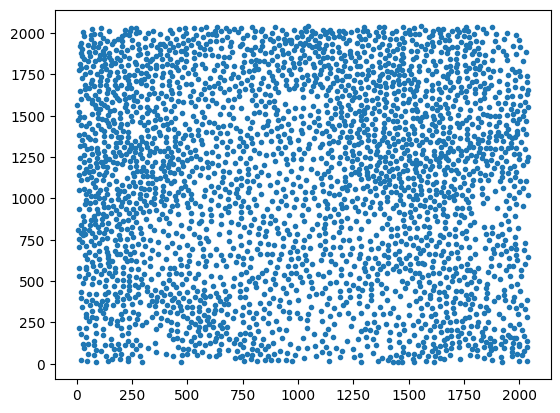

In [30]:
url = 'https://raw.githubusercontent.com/kolmar7/rdf/refs/heads/main/HaCaT%40pla-gel-CPNW%40PMMA(11x11%2Cx20)_2022-05-30_CellCounter_tile_x001_y002%20(1).xml'

#парсинг XML
def parsing_xml(xml_path: str, marker_type: int = 1):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    xc, yc = [], []
    for mtype in root.findall(".//Marker_Type"):
        t = mtype.findtext("Type")
        if not t or int(t.strip()) != marker_type:
            continue
        for m in mtype.findall(".//Marker"):
            x = m.findtext("MarkerX")
            y = m.findtext("MarkerY")
            if x and y:
                xc.append(int(x)); yc.append(int(y))
    return np.asarray(xc, dtype=np.int64), np.asarray(yc, dtype=np.int64)


#запуск
resp = urlopen(url, timeout=30)
X, Y = parsing_xml(resp, marker_type=1)

W = int(X.max()) + 1
H = int(Y.max()) + 1

# total square
S = W * H

N =  X.size

points = [Point(float(x), float(y)) for x, y in zip(X, Y)
          if np.isfinite(x) and np.isfinite(y)]
tree = STRtree(points)


plt.scatter(X, Y, marker='.')

## Using module `numpy` to calculate number of area of intersection of a ring and rectangle

In [31]:
def calculate_circle_area(i, j, r):
    """
    Количество пикселей (целочисленных координат) внутри круга
    (yy - i)^2 + (xx - j)^2 <= r^2 с учётом границ изображения H×W.
    i — индекс строки (y), j — индекс столбца (x). 0-based.
    """

    # вертикальные границы круга, обрезанные окном
    y0 = max(0, i - r)
    y1 = min(H - 1, i + r)
    if y0 > y1:
        return 0

    # расстояния по вертикали от центра до каждой строки в пределах круга
    dy = np.arange(y0, y1 + 1, dtype=np.int64) - i
    # горизонтальный полуразброс (целый) для каждой строки
    # (сколько колонок вправо/влево от j попадает в круг)
    xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)

    # для каждой строки находим допустимый интервал колонок в окне [0, W-1]
    left  = np.maximum(0, j - xrad)
    right = np.minimum(W - 1, j + xrad)

    # длина интервала по колонкам (если right<left, длина 0)
    counts = np.maximum(0, right - left + 1)

    return int(counts.sum())

def calculate_ring_area(i, j, r, dr):
  return calculate_circle_area(i, j, r+dr) - calculate_circle_area(i, j, r)

i, j = 100, 100
r, dr = 200, 30
%timeit calculate_ring_area(i, j, r, dr)

59.3 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Using module `shapely` to calculate area of intersection of a ring and rectangle

In [32]:
# frame for all x, y points
FRAME = Polygon([(0,0), (W,0), (W,H), (0,H)])


def calculate_area_shapely(cx, cy, r, deltar, resolution=8):
    """
    cx, cy:  центр круга
    r:       радиус круга
    deltar: приращение радиуса круга
    resolution: number of segments for quarter of circle
    """
    def circle_rect_intersection_area(cx, cy, r, resolution):
      if (cx + r <= W) & (cx - r >= 0) & (cy + r <= H) & (cy - r >= 0):
        area = np.pi * r**2
      else:
        circle = Point(cx, cy).buffer(r, resolution=resolution) # resolution ↑ => точнее аппроксимация
        area =   FRAME.intersection(circle).area
      return area


    s0 = circle_rect_intersection_area(cx, cy, r, resolution)
    s1 = circle_rect_intersection_area(cx, cy, r + deltar, resolution)
    return s1 - s0

# пример
%time calculate_area_shapely(cx=100, cy=100, r=200, deltar=2, resolution=8)


CPU times: user 796 µs, sys: 856 µs, total: 1.65 ms
Wall time: 1.48 ms


1045.295038616241

## Using module `numpy` to calculate number of points inside the ring

In [33]:
def count_points(cx, cy, r, deltar):
  distance2 = (X - cx)*(X - cx) + (Y - cy)*(Y - cy)
  r2 = r*r
  rdr2 = (r + deltar) * (r + deltar)
  mask = (distance2 >= r2) & (distance2 <= rdr2)
  count = np.count_nonzero(mask)
  return count

# пример
%timeit count_points(100, 100, 2000, 30)


28.5 µs ± 692 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Using module `shapely` to calculate number of points inside the ring

In [34]:
def count_points_shapely(cx, cy, r, deltar):
  circle = Point(cx, cy).buffer(r, resolution=16)
  candidates = [points[i] for i in tree.query(circle)]
  pc = prep(circle)                                # ускоряет множественные проверки
  count = sum(pc.covers(c) for c in candidates)
  return count

# пример
%timeit count_points_shapely(cx=100, cy=100, r=200, deltar=30)


968 µs ± 222 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Find density as number of points to square of intersection

In [35]:
def density(cx, cy, r, deltar):
  count  = count_points(cx, cy, r, deltar)
  relative_count = count / N
  square = calculate_ring_area(cx, cy, r, deltar)
  relative_square = square / S
  if square == 0:
    rho = 0
  else:
    rho = count / N  * S / square
  return rho

#density = np.vectorize(density)

# пример
%timeit density(cx=100, cy=100, r=200, deltar=30)

79.7 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Sweep for all possible radius averaged density




CPU times: user 25.5 s, sys: 29.9 ms, total: 25.5 s
Wall time: 26 s


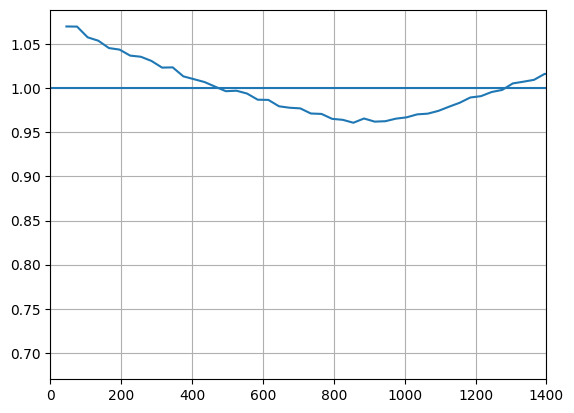

In [36]:
deltar = 30
r_max = min(W, H)

r_edges = np.arange(deltar, r_max+deltar, deltar, dtype=float)
R = 0.5 * (r_edges[:-1] + r_edges[1:])


#g = np.zeros(R.size)
#for i in range(N):
#  x, y = X[i], Y[i]
#  g += density(x, y, R, deltar )
# g /= N

%time g = [np.mean([density(X[i], Y[i], r, deltar) for i in range(N)]) for r in R]


plt.plot(R, g)
plt.axhline(1)
plt.xlim(0, 1400)
plt.grid()

### The same for uniform distribution

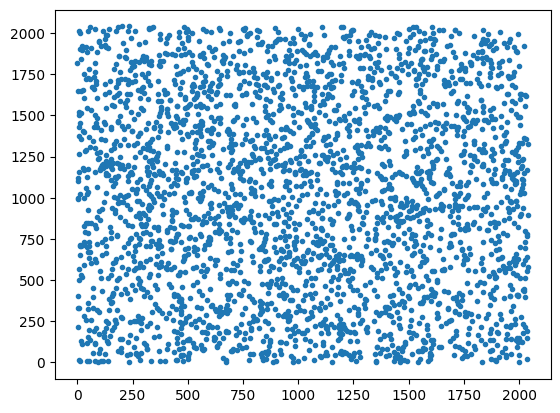

In [37]:
rng = np.random.default_rng(seed=123)
Xu = rng.uniform(0, W, size=N)
Yu = rng.uniform(0, H, size=N)
plt.scatter(Xu, Yu, marker='.')

In [38]:
%time gu = [np.mean([density(Xu[i], Yu[i], r, deltar) for i in range(N)]) for r in R]


/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in sqrt
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)
/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in cast
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)


CPU times: user 31.3 s, sys: 15.9 ms, total: 31.3 s
Wall time: 31.6 s


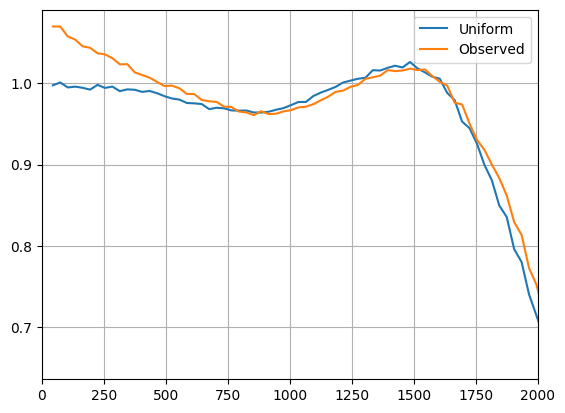

In [39]:
plt.plot(R, gu, label='Uniform')
plt.plot(R, g, label='Observed')
plt.legend()
plt.xlim(0, 2000)
plt.grid()

## test for a point in the center with growing radius

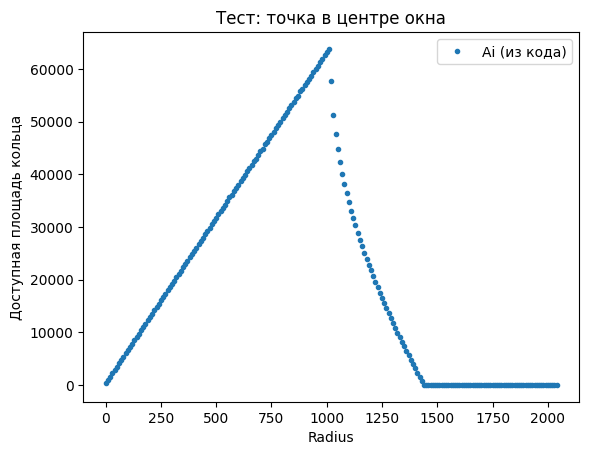

In [40]:
deltar = 10
R = np.arange(0, W, deltar)

xc, yc = W /2, H / 2

Ai = [calculate_ring_area(xc, yc, r, deltar) for r in R]


# график
plt.plot(R, Ai, '.', lw=2, label="Ai (из кода)")
#plt.plot(R, Ai_theory, 'r--', lw=2, label="Ai (аналитика)")
plt.xlabel("Radius")
plt.ylabel("Доступная площадь кольца")
plt.title("Тест: точка в центре окна")
plt.legend()
plt.show()